In [1]:
import cv2
# import pytesseract
import pandas as pd
import numpy as np
import segyio
from segyio import TraceField ,BinField
import matplotlib.pyplot as plt
# from segpy.dataset import Dataset
import logging
from pathlib import Path
from scipy import signal
import toml
from PIL import Image, ImageOps

logger = logging.getLogger(__name__)
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
%matplotlib inline
datafolder=r'D:\Ameyem\Bhugarbho\JOGMEC\SeismicSection\Vietnam\\'
crop_folder=datafolder+'cropped//'
import os
[f  for f in os.listdir(crop_folder) if '_crop.png' in f]

['0045_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ A-103_crop.png',
 '0047_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ A-108_crop.png',
 '0048_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ A-109_crop.png',
 '0049_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ A-111_crop.png',
 '0052_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ A-116_crop.png',
 '0054_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ A-117_crop.png',
 '0055_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ A-119_crop.png',
 '0254_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ 74-730_crop.png',
 '0371_1985_Block3_2D_Repro_1986_Time_UnMigrated_ 85-57_crop.png']

In [11]:
files=['0254_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ 74-730_crop.png']
files=['0254_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ 74-730_crop.jpg']
viennadf=pd.read_excel(datafolder+'Data List from JOGMEC_June2022.xlsx','Vietnam', skiprows=[0])
file=files[0]
key=2
timeranges={'103':[0,6],'108':[0,6],'109':[0,6],'111':[0,6],'116':[0,6],'117':[0,6],'119':[0,6],'0254':[0,5]}
inputdict=dict(dstpath=datafolder+file.replace('_crop.jpg','')+'_raw{}.sgy'.format(key),srcpath='bak_test2.sgy',
               mintime=1300,mxtime=1500,dt=1,iline=1, xline=169, offset=0)
def doubleInterval(filttrcs,dt):
    #Resampling at 4ms
#     four_secfilttrcs= 
    return filttrcs[::2,:],2*dt
# #     print(four_secfilttrcs.shape)
#     filttrcs=four_secfilttrcs.copy()
#     filttrcs=
#     filttrcs.astype(np.float64)
#     print(filttrcs.shape)
def halftheInterval(filttrcs,dt):
    #Resampling at 1ms
    resfilttrcs= np.zeros((filttrcs.shape[0]*2,filttrcs.shape[1]))
#     print(resfilttrcs.shape)

    resfilttrcs[::2,:]=filttrcs

    # filttrcs.shape
    for i in range(1,len(resfilttrcs[:,0])-1,2):
    #     print(i)
    #     if i==10: break
        resfilttrcs[i,:]=(resfilttrcs[i-1,:]+resfilttrcs[i+1,:])/2
#     filttrcs=resfilttrcs.copy()
#     filttrcs=
    return resfilttrcs.astype(np.float64),int(dt/2)
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def myplot(t,datalist,datainfolist,mtitle='Title'):
#     [data,lfdata,hfdata,output]
    plt.figure(figsize=(12,2))
#     plt.subplot(2, 1, 1)
#     plt.plot(t, data/max(data[nclip:])-np.mean(data/max(data[nclip:]))-lfdata, 'b-', label='data')
    k=0
    for data,info in zip(datalist,datainfolist):
        if k==0: data=data/max(data)
#         if k==0: data=data/max(data)-np.mean(data/max(data))
        plt.plot(t, data,  label=info)
        k+=1
#     plt.plot(t, output,'r-', label='filtered')
    plt.xlabel('Time [sec]')
    plt.title(mtitle)
    plt.grid()
    plt.legend()
    plt.show()
def ampspec(signal,dt,smooth=False): #dt in milliseconds
    SIGNAL = np.fft.fft(signal)
    freq = np.fft.fftfreq(signal.size, d=dt*0.001)
    keep = freq>=0
    SIGNAL = np.abs(SIGNAL[keep])
    freq = freq[keep]
    if smooth:
        freq0=np.linspace(freq.min(),freq.max()/2,freq.size*10)
        f = interp1d(freq, SIGNAL, kind='cubic')
        return freq0, f(freq0)
    else:
        return freq, SIGNAL
def plot_ampspec(freq,amp,name=None,img_fpath=None):
    '''
    plot_ampspec (C) aadm 2016-2018
    Plots amplitude spectrum calculated with fullspec (aageofisica.py).

    INPUT
    freq: frequency
    amp: amplitude
    f_peak: average peak frequency
    '''
    db = 20 * np.log10(amp)
    db = db - np.amax(db)
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5),facecolor='w')
    ax[0].plot(freq, amp, '-k', lw=2)
    ax[0].set_ylabel('Power')
    ax[1].plot(freq, db, '-k', lw=2)
    ax[1].set_ylabel('Power (dB)')
    for aa in ax:
        aa.set_xlabel('Frequency (Hz)')
        aa.set_xlim([0,np.amax(freq)/1.5])
        aa.set_xlim([0,100])
        aa.grid()
#         aa.axvline(f_peak, color='r', ls='-')
        if name!=None:
            aa.set_title(name, fontsize=16)
    if(img_fpath):
        plt.savefig(img_fpath)
def windowFilt(tarray,data,nclip=0,window=(3,80),order=3,retain_originalscale=False):
    fs=len(tarray)/((tarray[-1]-tarray[0])/1000)
    maxai=np.nanmax(data[nclip:])
    normdata=data[nclip:]/maxai
#     print(maxai)
#     meanai=np.nanmean(normdata)
#     normdata=normdata-meanai
    fc = window[0]  # Cut-off frequency of the filter
    w = fc / (fs / 2) # Normalize the frequency
#     order=order
    b, a = signal.butter(order, w, 'low')
    lowfreq_data = signal.filtfilt(b, a, normdata)

#     ########################################################
    normdata=normdata-lowfreq_data #removing low frequency component
#     ########################################################
    fc = window[1]  # Cut-off frequency of the filter 70 gave 36%, 12.6ms bs
    w = fc / (fs / 2) # Normalize the frequency fs/2 is the nyquist frequency
    b, a = signal.butter(order, w, 'low')
    window_freq_data = signal.filtfilt(b, a, normdata)
    highfreq_data=normdata-window_freq_data
    return lowfreq_data,window_freq_data,highfreq_data,maxai
def convert(image_filepath: Path, segy_filepath: Path=None, config_filepath: Path=None, *, force=False):
    image_filepath = Path(image_filepath)
    segy_filepath = (segy_filepath and Path(segy_filepath)) or image_filepath.with_suffix(".segy")
    config_filepath = (config_filepath and Path(config_filepath)) or image_filepath.with_suffix(".toml")

    logger.info("segy_filepath = %s", segy_filepath)
    logger.info("image_filepath = %s", image_filepath)
    logger.info("config_filepath = %s", config_filepath)
#     print(segy_filepath)
    return image_filepath,segy_filepath,config_filepath
def gethorizontalLineFilter(hf_data):
    hf_data[hf_data>0]=0
    hf_data[hf_data>-0.05]=0
    hf_data[hf_data<=-0.05]=1
    
    ids=np.where(hf_data==1)
    difids=np.diff(ids)
    difids[difids>1]
    spike_interval=int(np.median(difids[difids>1]))
    # ,np.mean(difids[difids>1])
    _,spikewidths=np.where(difids>1)
    spikewidth=int(np.median(np.diff(spikewidths)))
#     spike_interval,spikewidth
    halfspikew=int(spikewidth/2)
    x = np.arange(-halfspikew+1, 1,1)
    mfilter=x**2/40+0.01
    if len(mfilter)*2==spikewidth:
        mfilter=np.array([*mfilter,*mfilter[::-1]])
    else:
        mfilter=np.array([*mfilter,mfilter[-1],*mfilter[::-1]])
    smallfilter=np.append([1]*spike_interval,mfilter)
    times=int(len(sgray)/len(smallfilter))
    fullfilter=np.array([*smallfilter]*(times+1))[:len(sgray)]
    return fullfilter
def getHorizontalRawFilter(hf_data):
    hf_data[hf_data>0]=0
    hf_data[hf_data>-0.05]=1
    hf_data[hf_data<=-0.05]=0.01
    return hf_data
def getSegyKeyprops(file,viennadf,timeranges):
    # viennadf.Start
    names=viennadf['File Name'].apply(lambda x: str(x)[:-4]).values
    try:
        idx=np.where(names==file.replace('_crop.png',''))[0][0]
    except:
        idx=np.where(names==file.replace('_crop.jpg',''))[0][0]
    viennadf.iloc[idx]
    ntraces,startsp,endsp=viennadf.iloc[idx][['No. Traces','Start','End']]
    print('ntraces,startsp,endsp ',ntraces,startsp,endsp)
    strc=101
    ntrc=int(ntraces)
    etrc=strc+ntrc-1
    isset=False
    for key in timeranges:
        if key in file:
#             print(key,file)
            stime=timeranges[key][0]
            etime=timeranges[key][1]*1000
            isset=True
            break

    if not isset: 
        print('please check {} is not there in file: {}'.format(key,file))
        return 0
        
    return startsp,endsp,strc,etrc,ntrc,stime,etime

In [12]:
import numpy as np
from scipy import signal
def getCounts(mtrc):
    counts={}
    for i in np.unique(mtrc):
        counts[i]=[]
    count=0
    for i in range(1,len(mtrc)):
    #     st=mtrc[i-1]
        if mtrc[i-1]==mtrc[i]:
            count+=1
        else:
            counts[mtrc[i-1]].append(count)
            count=0
    return counts
def getOperatorStep(mtrc):
    counts=getCounts(mtrc)
    countmeans={}
    for k in counts  :
    #     print(k,': ',np.mean(counts[k]))
        countmeans[k]=np.mean(counts[k])
    mkeys=np.array(list(countmeans.keys()))
    nkeys=len(mkeys)
    opvalues=mkeys+0.5-nkeys/2
    nopdigits=[]
    for k in countmeans:
        val=np.round(countmeans[k])
        nopdigits.append(val)
    nopdigits
    op=[]
    for i in range(len(nopdigits)):
        op.extend([opvalues[i]]*int(nopdigits[i]))
    nopdigits=nopdigits[::-1][1:]
    opvalues=opvalues[::-1][1:]
    for i in range(len(nopdigits)):
        op.extend([opvalues[i]]*int(nopdigits[i]))
    op=np.array(op)
    op-=np.mean(op)
    return op
def getOperator(mtrc):
    
    counts=getCounts(mtrc)
    countmeans={}
    for k in counts  :
    #     print(k,': ',np.mean(counts[k]))
        countmeans[k]=np.mean(counts[k])
    hlfop_len=int(np.sum([countmeans[k] for k in countmeans]))
    f=10
    signal_len=2*hlfop_len/1000
    print(2*hlfop_len)
    dt=0.002

    # mlen=peak_loc*2
    mlen=2*signal_len
    peak_loc=mlen/2
    t = np.linspace(-peak_loc, mlen - peak_loc - dt, int(mlen / dt))

    # Shift time to the correct location
    # t_out = t + peak_loc  # time shift Ricker wavelet based on peak_loc

    # Generate Ricker wavelet signal based on reference
    op = (1 - 2 * np.pi ** 2 * f ** 2 * t ** 2) * np.exp(
        -np.pi ** 2 * f ** 2 * t ** 2)
    
    op=op-op.mean()
    return op
def getmydict(i,filttrcs,delrt):
    return {TraceField.TRACE_SEQUENCE_LINE: i+1,
 TraceField.TraceNumber: i+1,
 TraceField.EnergySourcePoint: i+1,
 TraceField.CDP: i+1,
 TraceField.SourceX: 0,
 TraceField.SourceY: 0,
 TraceField.LagTimeA: 0,
 TraceField.DelayRecordingTime: 0,
 TraceField.TRACE_SAMPLE_COUNT: filttrcs.shape[0],
 TraceField.TRACE_SAMPLE_INTERVAL: delrt*1000,
 TraceField.CDP_X: 0,
 TraceField.CDP_Y: 0,
 TraceField.ShotPoint: i+1*100}

# op=[-3,-1,2,4,2,-1,-3]

# op=[-5,-3,-1,2,3.5,7,3.5,2,-1,-3,-5]
# np.conv(traces[10],op)

def getOpProcTraces(traces,op,trange):
    halflenop=int(len(op)/2)
    proctrcs=[]
    for trc in traces:
    #     res=np.convolve(trc,op)[3:len(trc)+3]
        res=np.convolve(trc,op)[halflenop:len(trc)+halflenop]
        f = signal.resample(res, len(trange))
        proctrcs.append(f)
    return proctrcs

def getLowPassfilteredTraces(proctrcs):
    filttrcs=[]
    order = 6
    fs = 500.0       # sample rate, Hz
    cutoff = 35.0  # desired cutoff frequency of the filter, Hz
    freq=cutoff
    smpls2shift=round(900*pow(freq,-1.274))
    fromsample=smpls2shift
    # Filter the data, and plot both the original and filtered signals.
    for trc in proctrcs:
        y = butter_lowpass_filter(trc, cutoff, fs, order)
        filttrcs.append(np.append(y[fromsample:],np.zeros(fromsample)))
    return np.array(filttrcs)





import datetime 
def default_text_header(inputdict):
    iline, xline, offset,mypath=inputdict['iline'],inputdict['xline'], inputdict['offset'],inputdict['dstpath']
    lines = {
        1: "DATE %s" % datetime.date.today().isoformat(),
        2: "Name: %10s Type: 2D seismic"%mypath,
        3: "For Bhugarbho ",
        4: "Image to segy conversion by Ameyem Geosolutions",
        5: "First CDP: 1.000000 Last CDP: %03d.000000" % xline,
        6: "First SP:  1.000000 Last SP:  %03d.000000" % xline,
        8: " Time min: %03d max: %03d delta: %03d" %(inputdict['mintime'],inputdict['mxtime'], inputdict['dt']),
        9: " Lat min: - max: - delta: -",
        10: " Long min: - max: - delta: -",        
        11: "TRACE HEADER POSITION:",
        12: "  INLINE BYTES %03d-%03d    | OFFSET BYTES %03d-%03d" % (iline, iline + 4, int(offset), int(offset) + 4),
        13: "  CROSSLINE BYTES %03d-%03d |" % (xline, xline + 4),
        
        15: " Trace sample format: IEEE floating point",
        16: " Coordinate scale factor: 1.00000",
        17: "",
        18: " Binary header locations:",
        19: " Sample interval             : bytes 17-18",
        20: " Number of samples per trace : bytes 21-22",
        21: " Trace date format           : bytes 25-26",
        22: "",
        23: " Trace header locations:",
        24: " Inline number               : bytes 5-8",
        25: " SP Number                   : bytes 17-20",
        26: " CDP number                  : bytes 21-24",
        27: " Coordinate scale factor     : bytes 71-72",
        28: " X coordinate                : bytes 73-76",
        29: " Y coordinate                : bytes 77-80",
        30: " Trace start time/depth      : bytes 109-110",
        31: " Number of samples per trace : bytes 115-116",
        32: " Sample interval             : bytes 117-118",        
        39: "END EBCDIC HEADER",
    }
    rows = segyio.create_text_header(lines)
    rows = bytearray(rows, 'ascii')  # mutable array of bytes
    rows[-1] = 128  # \x80 -- Unsure if this is really required...
    return bytes(rows)  # immutable array of bytes that is compatible with strings


def saveAsSegy(filttrcs,inputdict=inputdict,delrt=2):
    # dstpath,len(spec.samples),filttrcs.shape[0]
    print(filttrcs.shape)   
    f = segyio.open( inputdict['srcpath'], iline=inputdict['iline'], xline=inputdict['xline'], strict=True, ignore_geometry=False, endian='big')
    spec = segyio.tools.metadata(f)
    spec.ilines=np.arange(1,filttrcs.shape[1]+1)
    spec.samples = np.arange(stime,etime+2,delrt)

    if len(spec.samples)!=filttrcs.shape[0]:
        print('.error() mismatch', len(spec.samples),filttrcs.shape[0])
        return False
    else:
        print('Reday to go')        
    rows=default_text_header(inputdict )
    theader=bytearray(rows)
    mybin=[]
    i=0
    with segyio.open(inputdict['srcpath'] , iline=inputdict['iline'], xline=inputdict['xline'], strict=True, ignore_geometry=False, endian='big') as src:
        with segyio.create(inputdict['dstpath'], spec) as dst:
            dst.text[0] = theader
            dst.header[i] = src.header[0]
            print(len(dst.header))
            for i,x in enumerate(dst.header[:]):
                x.update(getmydict(i,filttrcs,delrt))
            dst.bin = src.bin
            dst.bin.update({BinField.Interval:delrt*1000,BinField.Samples: filttrcs.shape[0]})
            print(dst.bin)
            dst.trace = list(filttrcs.T)            
    return True
def img2rawtrace(mthresh,stime,etime,ntrc): #key function need filters before
    thresh=mthresh.copy()
    trange=np.arange(stime,etime+1,2).astype(int)
    pixper_trc=thresh.shape[1]/ntrc
    print('ntrc,thresh.shape,pixper_trc ',ntrc,thresh.shape,pixper_trc)

    pixrange=np.arange(0,thresh.shape[1]+1,pixper_trc).astype(int)
    # # 
    # thresh[thresh<100]=0
    # thresh[thresh>100]=1
    tmean=100
    thresh[thresh<tmean]=0
    thresh[thresh>tmean]=1
    # plt.hist(thresh)

    traces=[]
    for i in range(len(pixrange)-1):
    #     print(pixrange[i],pixrange[i+1])
        trc=thresh[:,pixrange[i]:pixrange[i+1]].sum(axis=1)
        traces.append(trc)
    traces=np.array(traces)
    return traces
def getDirections(case):
    useHorfilter=False
    crude_hor_filter= False
    useStepOp=False
    if case==1:
        useHorfilter=True
        
    if case==2:
        useHorfilter=True
        crude_hor_filter= True
        
    if case==3:       
        useHorfilter=True
        useStepOp=True
        
    if case==4:
        useHorfilter=True
        crude_hor_filter= True
        useStepOp=True   
    if case==5:
        useStepOp=True 

    return crude_hor_filter,useStepOp,useHorfilter

In [13]:
file
# viennadf
# timeranges

'0254_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ 74-730_crop.jpg'

In [14]:
# file=files[1]

# # print(stime,etime,file)


startsp,endsp,strc,etrc,ntrc,stime,etime=getSegyKeyprops(file,viennadf,timeranges)
startsp,endsp,strc,etrc,ntrc,stime,etime
# twt[0],twt[-1]

ntraces,startsp,endsp  1165.0 1140.0 2304.0


(1140.0, 2304.0, 101, 1265, 1165, 0, 5000)

In [16]:
ntrace=1201
ntrc=ntrace
strc=1114
etrc=strc+ntrc


In [18]:
# datafolder=r'D:\Ameyem\Bhugarbho\JOGMEC\SeismicSection\Vietnam\cropped\cleaned\\'
datafolder=r'D:\Ameyem\Bhugarbho\JOGMEC\SeismicSection\Vietnam\cropped\\'
# file='0045_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ A-103_crop.png'
image = cv2.imread(datafolder+file)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

sgray=gray.sum(axis=1)
gray.shape

(3968, 12091)

Case:  6
ntrc,thresh.shape,pixper_trc  1201 (3968, 12091) 10.06744379683597
40
(1201, 3968) (1201, 3968)
(2501, 1201)
Reday to go
1201
{JobID: 1, LineNumber: 1, ReelNumber: 1, Traces: 1, AuxTraces: 0, Interval: 2000, IntervalOriginal: 0, Samples: 2501, SamplesOriginal: 0, Format: 5, EnsembleFold: 1, SortingCode: 4, VerticalSum: 1, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, Sweep: 0, SweepChannel: 0, SweepTaperStart: 0, SweepTaperEnd: 0, Taper: 0, CorrelatedTraces: 0, BinaryGainRecovery: 0, AmplitudeRecovery: 0, MeasurementSystem: 1, ImpulseSignalPolarity: 1, VibratoryPolarity: 0, ExtAuxTraces: 0, ExtSamples: 0, ExtSamplesOriginal: 0, ExtEnsembleFold: 0, SEGYRevision: 0, SEGYRevisionMinor: 0, TraceFlag: 0, ExtendedHeaders: 0}


C:\Users\ArunBabu\anaconda3\lib\site-packages\segyio\utils.py:23: RuntimeWarning: Implicit conversion from float64 to float32 (narrowing)
  warnings.warn(msg.format(x.dtype, dtype), RuntimeWarning)


Done export.. D:\Ameyem\Bhugarbho\JOGMEC\SeismicSection\Vietnam\cropped\\0254_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ 74-730_raw1.sgy


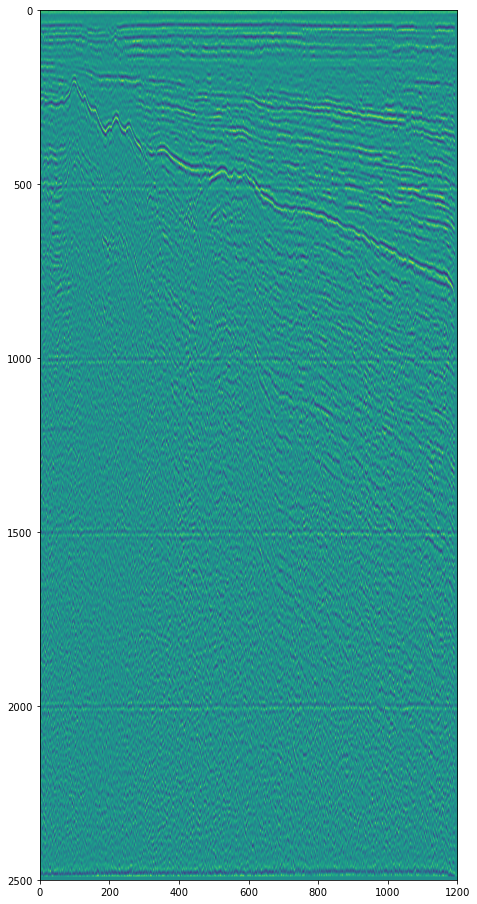

In [19]:
# bestcases={1:1,2:3,3:6}
bestcases={1:6}
for key in bestcases:
    case=bestcases[key]
# for case in range(1,7):
    print('Case: ',case)
    crude_hor_filter,useStepOp,useHorfilter=getDirections(case)
    #Horizontal filter calculation to remove horizontal lines
    twt=list(range(len(sgray)))
    lf_data,wf_data,hf_data,xmaxnormmeans=windowFilt(twt,sgray,nclip=0,window=(1,10),order=4)

    if useHorfilter:
        if not crude_hor_filter:
            hlfilter=gethorizontalLineFilter(hf_data) #median gap found and kept lo values to nullify horizontal line
        else:
            hlfilter=getHorizontalRawFilter(hf_data) #filter generate with crude way, line gaps are filled with 0.1 values

    mthresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    traces=img2rawtrace(mthresh,stime,etime,ntrc)

    #Operator for smooth trace
    trcno=200
    mtrc=traces[trcno]

    if useHorfilter:
        mtrc=mtrc*hlfilter
    
    if not useStepOp:
        op=getOperator(mtrc)
    else:
        op=getOperatorStep(mtrc)

    # Filter or not and make resultant traces as float64 type
    if useHorfilter:
        result=(np.array(traces)*hlfilter*1000).astype(np.float64)
    else:
        result=(np.array(traces)*1000).astype(np.float64)

    print(traces.shape,result.shape)
    trange=np.arange(stime,etime+1,2).astype(int)
    proctrcs= getOpProcTraces(result,op,trange)
    filttrcs= getLowPassfilteredTraces(proctrcs)
    
    inputdict=dict(dstpath=datafolder+file.replace('_crop.jpg','')+'_raw{}.sgy'.format(key),srcpath='bak_test2.sgy',
               mintime=1300,mxtime=1500,dt=1,iline=1, xline=169, offset=0)

    status=saveAsSegy(filttrcs.T,inputdict=inputdict,delrt=2)
    if status:    
        print('Done export..',inputdict['dstpath'])
    else:
        print('Export incomplete..')
    fig=plt.figure(figsize=(16,16))
#     plt.imshow(filttrcs.T[:800,-800:])
    plt.imshow(filttrcs.T)
    plt.show()

In [90]:
len(mtrc),len(hlfilter),len(hf_data)

(3011, 3007, 3007)

ntrc,thresh.shape,pixper_trc,pixper_trc*ntrc  3817 (3007, 21340) 5.590778097982709 21340.0


,0,1,2,3,4,5,6,7,8,9,...,3807,3808,3809,3810,3811,3812,3813,3814,3815,3816
0,0,2,1,1,1,1,2,1,1,1,...,1,1,1,2,1,1,2,1,0,0
1,0,2,1,1,1,1,2,1,1,1,...,1,1,1,2,1,1,2,1,0,0
2,0,1,1,2,1,1,2,1,1,1,...,1,1,1,1,1,1,2,1,0,0
3,0,2,1,2,1,1,2,1,1,1,...,1,1,1,2,1,1,2,1,0,0
4,0,1,1,2,1,1,2,1,1,1,...,1,1,1,1,1,1,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# mfilter
plt.plot(op,'r')
plt.show()
plt.imshow(result.T)

3007


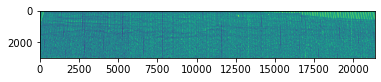

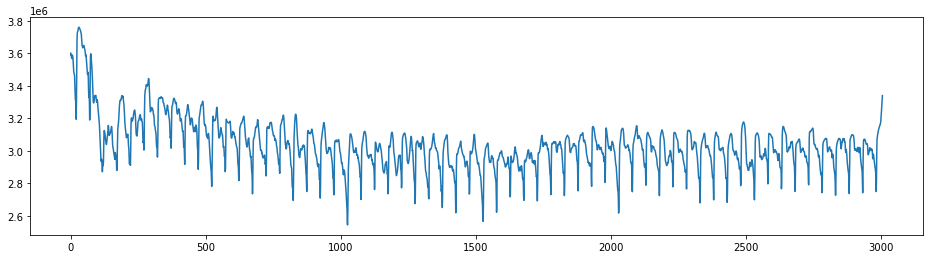

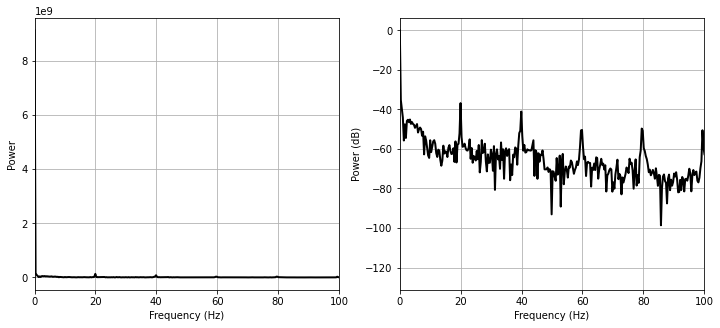

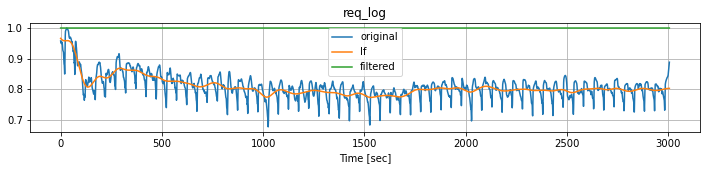

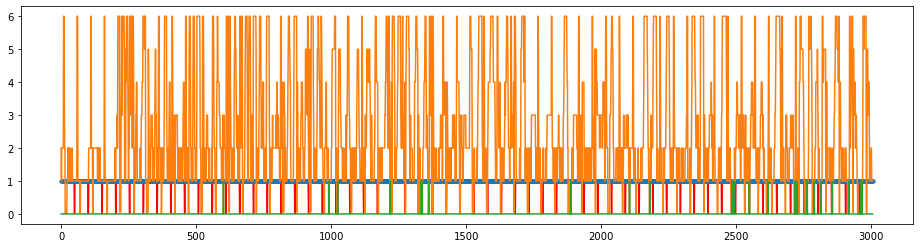

In [59]:
#key insights

plt.imshow(gray)
# thresh[:10,:100]
sgray=gray.sum(axis=1)
print(len(sgray))
fig=plt.figure(figsize=(16,4))
plt.plot(sgray)
freq, SIGNAL =ampspec(sgray,1,smooth=False)
plot_ampspec(freq, SIGNAL,name=None,img_fpath=None)


myplot(twt,[sgray/xmaxnormmeans,lf_data+wf_data,hf_data],['original','lf','filtered','hfdata'],mtitle='req_log')
# myplot(twt,[sgray/xmaxnormmeans,(lf_data+wf_data)],['original','filtered','hfdata'],mtitle='req_log')
fig=plt.figure(figsize=(16,4))
plt.plot(hlfilter,'-r')

plt.plot(hlfilter_raw,'.')


# plt.imshow( np.array(traces).T[:40,:20])
otrc=traces[2928]
otrc=otrc*fullfilter
# plt.figure(figsize=(16,4))
# plt.plot(otrc)
mtrc=otrc.copy()
plt.plot(mtrc)
mtrc[mtrc>0]=10
dtrc=np.diff(mtrc.astype(float))
dtrc[dtrc>0]=1
dtrc[dtrc<0]=0
round(len(dtrc)/dtrc.sum())
plt.plot(dtrc)

# len(trange),pixper_trc
# traces.min()

# plt.figure(figsize=(16,4))
# plt.plot(otrc,'r')
# plt.plot(otrc*fullfilter,'g')

(3817, 3007) (3007,) (3817, 3007)


In [334]:


# x = np.arange(-hlfop_len+1, 1,1)
# mfilter=100-np.power(x,4)/(hlfop_len*10)+0.01
# op=np.array([*mfilter,*mfilter[::-1]])


In [60]:
# traces=(np.array(traces)*1000).astype(np.float64)
# nopdigits
# plt.plot(fullfilter)
# fullfilter

In [ ]:
# plt.imshow(np.array(filttrcs).T)

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(proctrcs[trcno]),len(proctrcs[trcno]),len(proctrcs[trcno])
plt.show()
# fromsample=5
# plt.plot(t[:len(t)-fromsample], , 'g-', linewidth=2, label='filtered data')
plt.figure(figsize=(16,4))
plt.plot(proctrcs[trcno]),len(proctrcs[trcno]),len(proctrcs[trcno])
plt.plot(filttrcs[trcno]),len(filttrcs[trcno]),len(filttrcs[trcno])